## 0. Carregamento das bibliotecas

In [1]:
# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scikitplot as skplt

# Machine learning 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# balanceamento
from imblearn.under_sampling import RandomUnderSampler

# Grid e Random Search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Metricas de avaliacao
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score

# remover warning
import warnings
warnings.filterwarnings('ignore')

## 1. Carregamento dos dados

Após ter os dados pré-processados, podemos começar a construir nosso modelo.

In [2]:
df = pd.read_csv("covid_11_marco_pre_process.csv", sep=';')

## 2. Treino e teste

Antes de dividirmos nossos dados, vamos verificar o balanceamento dos mesmos.


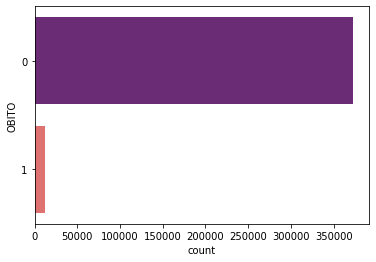

In [3]:
sns.countplot(y='OBITO', data=df, palette="magma");

In [4]:
(df['OBITO'].sum()/df.shape[0]) * 100

3.1673632894084807

Podemos ver que o nosso conjunto de dados está desbalanceado. Mais precisamente, apenas 02.09% dos dados são Óbitos. Se construíssemos um modelo preditivo que classificasse os dados apenas como 0 (Recuperado), teríamos um modelo com 97.91% de acurácia. 

In [5]:
from sklearn.dummy import DummyClassifier

In [6]:
X = df.drop('OBITO', axis=1)
y = df['OBITO']
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.9683263671059152

Queremos evitar esse "comportamento ingênuo".

#### 2.1 Como lidar com dados desbalanceados

Alguns exemplos de situações onde o desbalanceamento é quase certo são problemas de detecção de fraude e diagnóstico médicos - é intuitivo pensar que existem mais transações lícitas que criminosas, ou que o conjunto de pessoas diagnosticadas com câncer é bem menor que o conjunto de pessoas sem a doença.

Ignorar esse fato e treinar um algoritmo em cima do conjunto de dados original, pulando uma etapa intermediária de balanceamento dos dados, pode ter impactos diretos no seu projeto de Data Science.

#### 2.2 Consequências dos dados desbalanceados
Se você está construindo um modelo de machine learning para classificação, por exemplo, a consequência desse desequilíbrio é que o modelo terá uma tendência a dar muitos "alarmes falsos".

Ou seja, na prática ele irá responder muito bem entradas para as classes majoritárias, mas terá um desempenho inferior para as minoriárias.

No exemplo de detecção de fraude com cartões de crédito (onde o número de transações financeiras normais é bem maior que o número de transações fraudulentas), um classificador tenderá a apresentar muitos falsos negativos - uma situação indesejável para um banco, obviamente.

Em um trade-off, seria preferível "errar para mais" e ter uma quantidade maior de falsos positivos. Aliás, aposto que você já teve seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito, não é mesmo?!

Teoricamente, um dataset que possua qualquer classe com mais de 50% das entradas já é considerado desbalanceado. No entanto, há situações extremas onde você vai encontrar proporções maiores que 99:1.

Existem várias abordagens para lidar com dados desbalanceados, cada uma com seus prós e contras. Neste artigo, irei mostrar alguns dos métodos mais populares para você incluir desde já no seu arsenal.

#### 2.3 Métodos para lidar com datasets desbalanceados

Há diversas maneiras para atacar o problema de dados desbalanceados, que envolvem desde a construção de algoritmos específicos até a aplicação de algoritmos mais avançados como Recognition-based Learning e Cost-sensitive Learning.

No entanto, uma outra abordagem bem mais simples tem sido amplamente usada (com ótimos resultados), a abordagem *sampling*.

*Sampling* é um pré-processamento que visa minimizar as discrepâncias entre as classes por meio de uma reamostragem do dataset original. Para gerar um conjunto balanceado, são usadas normalmente as seguintes técnicas:

 - Over-sampling: cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de clustering ou sinteticamente.

 - Under-sampling: reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Além dessas duas técnicas de *sampling*, existem também os advanced sampling methods, como SMOTE e ADASYN, onde instâncias são adicionadas ou removidas adaptativamente.

Para isso, podemos usar abordagens que levam em conta apenas a avaliação do modelo, ou técnicas para rebalanceamento como a **undersampling**, que consiste em reamostrar a classe majoritária (nesse caso, recuperado) e manter apenas uma parte desses pontos.

![under sampling](resampling.png)

#### *tradeoff*
Ao usar um método de reamostragem (por exemplo, para obter tantos dados de ÓBITO quanto de RECUPERADOS), mostramos as proporções erradas das duas classes para o classificador durante o treinamento. O classificador treinado dessa maneira terá uma precisão menor nos dados de teste reais futuros do que o classificador treinado no conjunto de dados inalterado. Na verdade, as verdadeiras proporções das classes são importantes para saber para classificar um novo ponto e essa informação foi perdida ao reamostrar o conjunto de dados. 

- [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)
- [Learning pattern classification tasks with imbalanced data sets](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1806&context=infopapers)
- [There is No Free Lunch in Data Science](https://www.kdnuggets.com/2019/09/no-free-lunch-data-science.html)

#### 2.3 Divisão treino e teste e balanceamento

Vamos utilizar o `train_test_split` com 30% dos dados para test, e random_state em 42, para replicabilidade do código.

Para balanceamento, utilizaremo do `RandomUnderSampler` do imblearn.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('OBITO', axis=1), df['OBITO'], test_size=0.3, random_state=42)

In [8]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

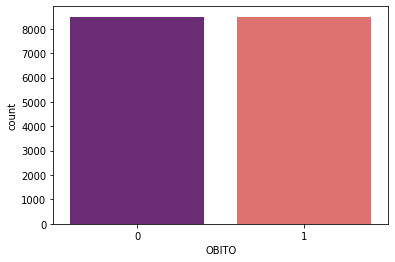

In [9]:
sns.countplot(y_train_rus, palette='magma');

# 3.Algoritmos de aprendizagem de máquina

Vamos utilizar esses algoritmos:

 - Decision Tree (DT)
 - Random Forest (RF)
 - Gausian Naive Bayes (GaussianNB)
 - Linear SVC (SVM)
 - Multilayer Perceptron (MLP)
 - Gradient Boosted Trees (XGBoost)
          
## 3.0 Métricas de avaliação

Como saber se meu modelo previu bem? Como saber se ele prevê bem a classe que queremos (Óbito)? Essas e outras questões podemos entender com as matrizes de confusão.

#### Matriz de confusão

![Matriz de confusao](confusion_matrix.png)

É uma tabela que mostra as frequências de classificação para cada classe do modelo. Ou seja, ela mostra a quantidade de acertos e erros do modelo, e nos mostra as frequências:

 - **Verdadeiro positivo** (*true positive* - TP): ocorre quando no conjunto real, a classe que estamos buscando foi prevista corretamente. Por exemplo, quando o paciente veio a óbito e o modelo previu corretamente que ele veio a falecer. 
 - **Falso positivo** (*false positive* - FP): ocorre quando no conjunto real, a classe que estamos buscando prever foi prevista incorretamente. Exemplo: O paciente foi recuperado, mas o modelo disse que ele veio a óbito
 - **Verdadeiro negativo** (*true negative* - TN): ocorre quando no conjunto real, a classe que não estamos buscando prever foi prevista corretamente. Exemplo: o paciente foi recuperado, e o modelo previu corretamente que ele não veio a óbito.
 - **Falso negativo** (*false negative* - FN): ocorre quando no conjunto real, a classe que não estamos buscando prever foi prevista incorretamente. Por exemplo, quando o paciente era óbito, e o modelo previu que seria recuperado.
 
 
Através desses quatro valores, seremos capazes de calcular os indicadores: Acurácia, Precisão, Revocação (sensibilidade ou *recall*) e F1 Score.

#### Métricas de avaliação decorrentes da matriz de confusão

 **Acurácia**
 Indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
  
 $acuracia = \frac{TP + TN}{TP + FP + TN + FN} = \frac{predicoes corretas}{todasaspredicoes}$
 
 é uma boa indicação geral de como o modelo performou. Porém, pode haver situações em que ela é enganosa. Por exemplo, na criação de um modelo de identificação de fraudes em cartões de crédito, o número de casos considerados como fraude pode ser bem pequeno em relação ao número de casos considerados legais. Para colocar em números, em uma situação hipotética de 280000 casos legais e 2000 casos fraudulentos, um modelo simplório que simplesmente classifica tudo como legal obteria uma acurácia de 99,3%. Ou seja, você estaria validando como ótimo um modelo que falha em detectar fraudes.
 
 
 **Precisão** (Valor Preditivo Positivo)
 Entre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas; (precisão de 1.0 ou 100% significa que não houve nenhum falso positivo.)
 
 Responde a pergunta: dos exemplos classificados como positivos, quantos realmente são positivos? 
se o valor para a precisão fosse de 90%, isto indicaria que a cada 100 pacientes classificados como óbito, é esperado que 90 tenham de fato venham a falecer.
 
 $precisao = \frac{TP}{TP + FP}$
  
 A precisão pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos. Por exemplo, ao classificar uma ação como um bom investimento, é necessário que o modelo esteja correto, mesmo que acabe classificando bons investimentos como maus investimentos (situação de Falso Negativo) no processo. Ou seja, o modelo deve ser preciso em suas classificações, pois a partir do momento que consideramos um investimento bom quando na verdade ele não é, uma grande perda de dinheiro pode acontecer.
 
 **Sensibilidade/*recall***
 
 Dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas; (recall de 1.0 ou 100% significa que não houve nenhum falso negativo.)
 
 Responde a questão: de todos os exemplos que são positivos, quantos foram classificados corretamente como positivos? 
se o valor para a sensiblidade fosse de 95%, isto indicaria que a cada 100 pacientes que vieram a falecer, é esperado que apenas 95 sejam corretamente identificados como óbito.
 
 $sensibilidade = \frac{TP}{TP + FN}$
 
 Pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes doentes, mesmo que classifique alguns saudáveis como doentes (situação de Falso Positivo) no processo. Ou seja, o modelo deve ter alto *recall* (sensibilidade), pois classificar pacientes doentes como saudáveis pode ser uma tragédia.
 
 **F1 Score**
 média harmônica entre precisão e sensibilidade.
 
 $f1score = 2 * \frac{precisao * sensibilidade}{precisao + sensibilidade}$
 
 é simplesmente uma maneira de observar somente 1 métrica ao invés de duas (precisão e recall) em alguma situação. É uma média harmônica entre as duas, que está muito mais próxima dos menores valores do que uma média aritmética simples. Ou seja, quando tem-se um F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo.

 

In [10]:
def run_model(model, X_train, y_train, name):
    # fazer as previsões em cima dos dados de teste
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if (isinstance(model, LinearSVC)):
        y_proba=0
        return y_pred, y_proba
    y_proba = model.predict_proba(X_test)
    if (isinstance(model, DecisionTreeClassifier)):
        pass #TODO: Plotar a arvore
    print(name)
    skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.show()
    #skplt.metrics.plot_roc(y_test, y_proba)
    #plt.show()
    return y_pred, y_proba

Árvore de decisão


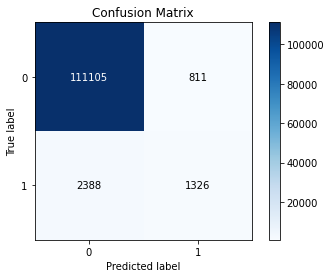

Floresta aleatória


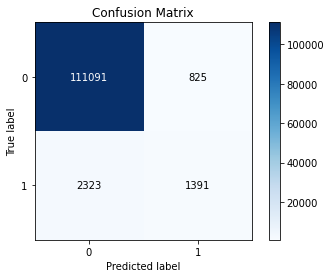

In [11]:
models = [DecisionTreeClassifier(), 
          RandomForestClassifier(),
          ]

verbose_models = ['Árvore de decisão', 'Floresta aleatória',]

accuracy_dict = {}
roc_auc_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}
for name, model in zip(verbose_models, models):
    y_pred, y_proba = run_model(model, X_train, y_train, name)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)
    roc_auc_dict[name] = roc_auc_score(y_test, y_pred)
    precision_dict[name] = precision_score(y_test, y_pred) 
    recall_dict[name] = recall_score(y_test, y_pred)
    f1_score_dict[name] = f1_score(y_test, y_pred)

In [12]:
metrics = pd.DataFrame.from_dict(accuracy_dict, orient='index', columns=['Acurácia'])
metrics = metrics.join(pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC']))
metrics = metrics.join(pd.DataFrame.from_dict(precision_dict, orient='index', columns=['Precisão']))
metrics = metrics.join(pd.DataFrame.from_dict(recall_dict, orient='index', columns=['Sensibilidade']))
metrics = metrics.join(pd.DataFrame.from_dict(f1_score_dict, orient='index', columns=['F1-Score']))

In [13]:
metrics

,Acurácia,ROC AUC,Precisão,Sensibilidade,F1-Score
Árvore de decisão,0.972334,0.674890,0.620496,0.357027,0.453256
Floresta aleatória,0.972775,0.683579,0.627708,0.374529,0.469140


In [14]:
metrics.index.rename('Modelo', inplace=True)
metrics.reset_index(inplace=True)
df = metrics.melt('Modelo', var_name='Métrica',  value_name='Score')

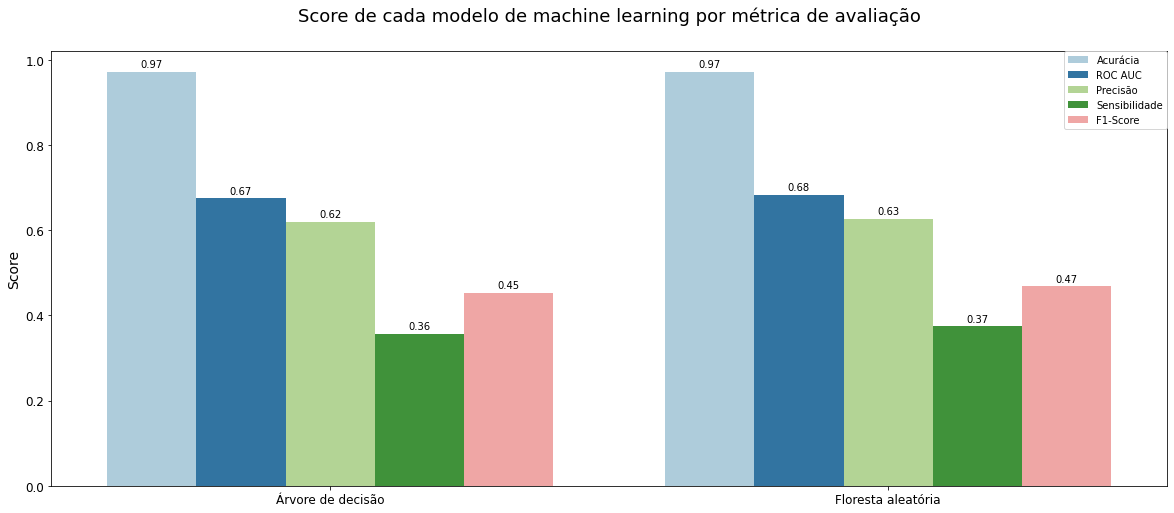

In [15]:
plt.rc('figure', figsize=(20, 8))
ax = sns.barplot(x='Modelo', y='Score', hue='Métrica', data=df, palette='Paired')

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2 # divide por 2 pra ficar no meio
            _y = p.get_y() + p.get_height()+ 0.01 # mais 0.01 pra nao ficar colado na altura da barra
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=10, color='black',) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
show_values_on_bars(ax)

ax.set_title('Score de cada modelo de machine learning por métrica de avaliação', fontsize=18, pad=30);
ax.set_ylabel('Score', fontsize=14)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0);

Árvore de decisão


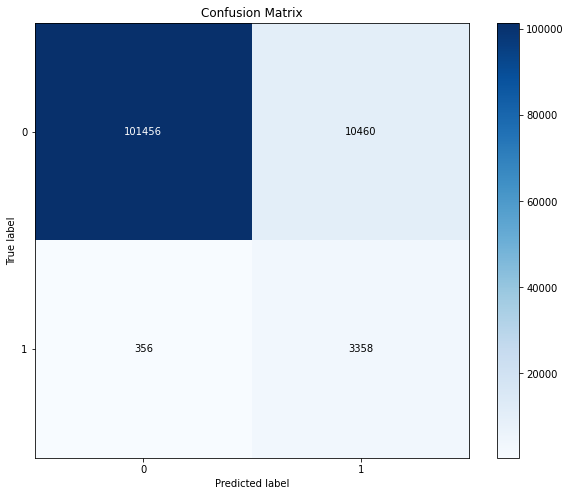

Floresta aleatória


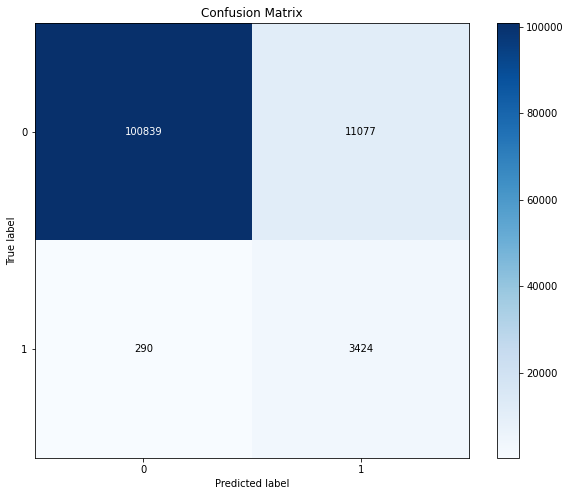

In [16]:
"""models = [LogisticRegression(max_iter=1000), 
          DecisionTreeClassifier(), 
          KNeighborsClassifier(n_neighbors = 5), 
          GaussianNB(), 
          LinearSVC(), 
          RandomForestClassifier(), 
          MLPClassifier(),
          XGBClassifier()]"""

"""verbose_models = ['Regressão logística', 'Árvore de decisão', 'KNN', 
                  'Naive Bayes Gaussiano', 'Linear SVM', 'Floresta aleatória', 
                  'Multilayer perceptron', 'XGBoost']"""

plt.rc('figure', figsize=(10, 8))
models = [DecisionTreeClassifier(), 
          RandomForestClassifier()]

verbose_models = ['Árvore de decisão', 'Floresta aleatória']
accuracy_dict = {}
roc_auc_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}
for name, model in zip(verbose_models, models):
    y_pred, y_proba = run_model(model, X_train_rus, y_train_rus, name)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)
    roc_auc_dict[name] = roc_auc_score(y_test, y_pred)
    precision_dict[name] = precision_score(y_test, y_pred) 
    recall_dict[name] = recall_score(y_test, y_pred)
    f1_score_dict[name] = f1_score(y_test, y_pred)

In [17]:
metrics = pd.DataFrame.from_dict(accuracy_dict, orient='index', columns=['Acurácia'])
metrics = metrics.join(pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC']))
metrics = metrics.join(pd.DataFrame.from_dict(precision_dict, orient='index', columns=['Precisão']))
metrics = metrics.join(pd.DataFrame.from_dict(recall_dict, orient='index', columns=['Sensibilidade']))
metrics = metrics.join(pd.DataFrame.from_dict(f1_score_dict, orient='index', columns=['F1-Score']))

In [18]:
metrics

,Acurácia,ROC AUC,Precisão,Sensibilidade,F1-Score
Árvore de decisão,0.906460,0.905342,0.243016,0.904146,0.383071
Floresta aleatória,0.901695,0.911471,0.236122,0.921917,0.375954


In [19]:
metrics.index.rename('Modelo', inplace=True)
metrics.reset_index(inplace=True)
df = metrics.melt('Modelo', var_name='Métrica',  value_name='Score')

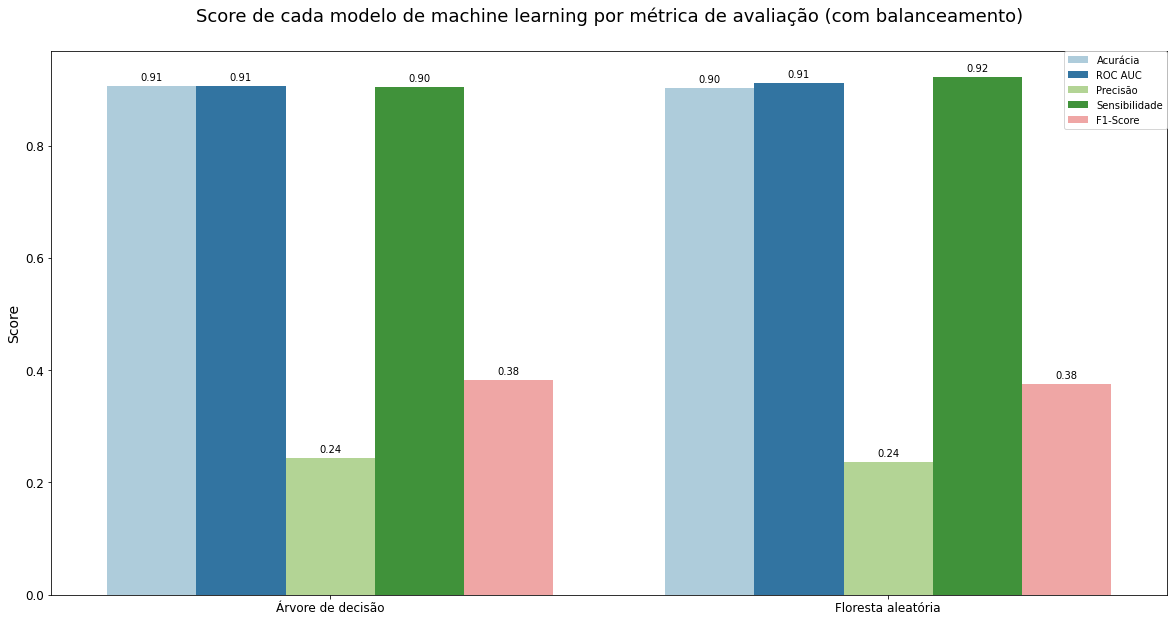

In [20]:
plt.rc('figure', figsize=(20, 10))
ax = sns.barplot(x='Modelo', y='Score', hue='Métrica', data=df, palette='Paired')

        
show_values_on_bars(ax)

ax.set_title('Score de cada modelo de machine learning por métrica de avaliação (com balanceamento)', fontsize=18, pad=30);
ax.set_ylabel('Score', fontsize=14)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0);

## Cross Validation

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold
from sklearn.metrics import make_scorer

In [22]:
models = [DecisionTreeClassifier(), 
          RandomForestClassifier()]

verbose_models = ['Árvore de decisão', 'Floresta aleatória']

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

print("Random undersampling")
for name, model in zip(verbose_models, models):
    print(name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(model, X, y, cv = cv, return_train_score=False, scoring=scoring)
    print("accuracy: %.2f" % (results['test_accuracy'].mean() * 100))
    print("precision: %.2f" % (results['test_precision'].mean() * 100))
    print("recall: %.2f" % (results['test_recall'].mean() * 100))
    print("f1_score: %.2f" % (results['test_f1_score'].mean() * 100))
    print()

Random undersampling
Árvore de decisão
accuracy: 97.26
precision: 61.42
recall: 35.93
f1_score: 45.32

Floresta aleatória
accuracy: 97.28
precision: 61.32
recall: 37.94
f1_score: 46.86



In [23]:
scoring = {'precision_weighted': make_scorer(precision_score, average='weighted'), 
           'recall_weighted': make_scorer(recall_score, average='weighted')}

print("Random undersampling")
for name, model in zip(verbose_models, models):
    print(name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(model, X, y, cv = cv, return_train_score=False, scoring=scoring)
    print("Precisão ponderado: %.2f" % (results['test_precision_weighted'].mean() * 100))
    print("Recall ponderado: %.2f" % (results['test_recall_weighted'].mean() * 100))
    print()

Random undersampling
Árvore de decisão
Precisão ponderado: 96.78
Recall ponderado: 97.26

Floresta aleatória
Precisão ponderado: 96.83
Recall ponderado: 97.27



In [24]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

In [25]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

print("Random undersampling - Scores")
for name, model in zip(verbose_models, models):
    print(name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(model, X_rus, y_rus, cv = cv, return_train_score=False, scoring=scoring)
    print("accuracy: %.2f" % (results['test_accuracy'].mean() * 100))
    print("precision: %.2f" % (results['test_precision'].mean() * 100))
    print("recall: %.2f" % (results['test_recall'].mean() * 100))
    print("f1_score: %.2f" % (results['test_f1_score'].mean() * 100))
    print()

Random undersampling - Scores
Árvore de decisão
accuracy: 90.57
precision: 90.80
recall: 90.29
f1_score: 90.54

Floresta aleatória
accuracy: 91.29
precision: 90.63
recall: 92.10
f1_score: 91.36



In [26]:
scoring = {'precision_weighted': make_scorer(precision_score, average='weighted'), 
           'recall_weighted': make_scorer(recall_score, average='weighted')}

print("Random undersampling - ponderados")
for name, model in zip(verbose_models, models):
    print(name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(model, X_rus, y_rus, cv = cv, return_train_score=False, scoring=scoring)
    print("Precisão ponderado: %.2f" % (results['test_precision_weighted'].mean() * 100))
    print("Revocação ponderado: %.2f" % (results['test_recall_weighted'].mean() * 100))
    print()

Random undersampling - ponderados
Árvore de decisão
Precisão ponderado: 90.59
Revocação ponderado: 90.59

Floresta aleatória
Precisão ponderado: 91.19
Revocação ponderado: 91.17



In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(model, X_rus, y_rus, cv=5)
conf_mat = confusion_matrix(y_rus, y_pred)

In [28]:
conf_mat

array([[11042,  1166],
       [  967, 11241]])

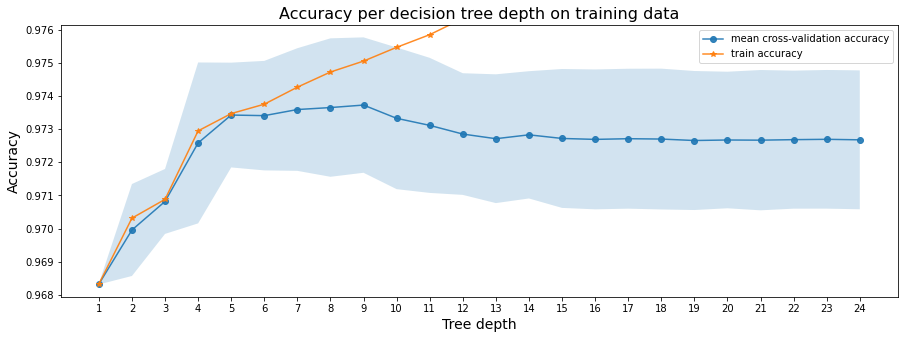

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X, y, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [30]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

clf = DecisionTreeClassifier(random_state = 777, max_depth=4,criterion='gini')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(clf, X_rus, y_rus, cv = cv, return_train_score=False, scoring=scoring)

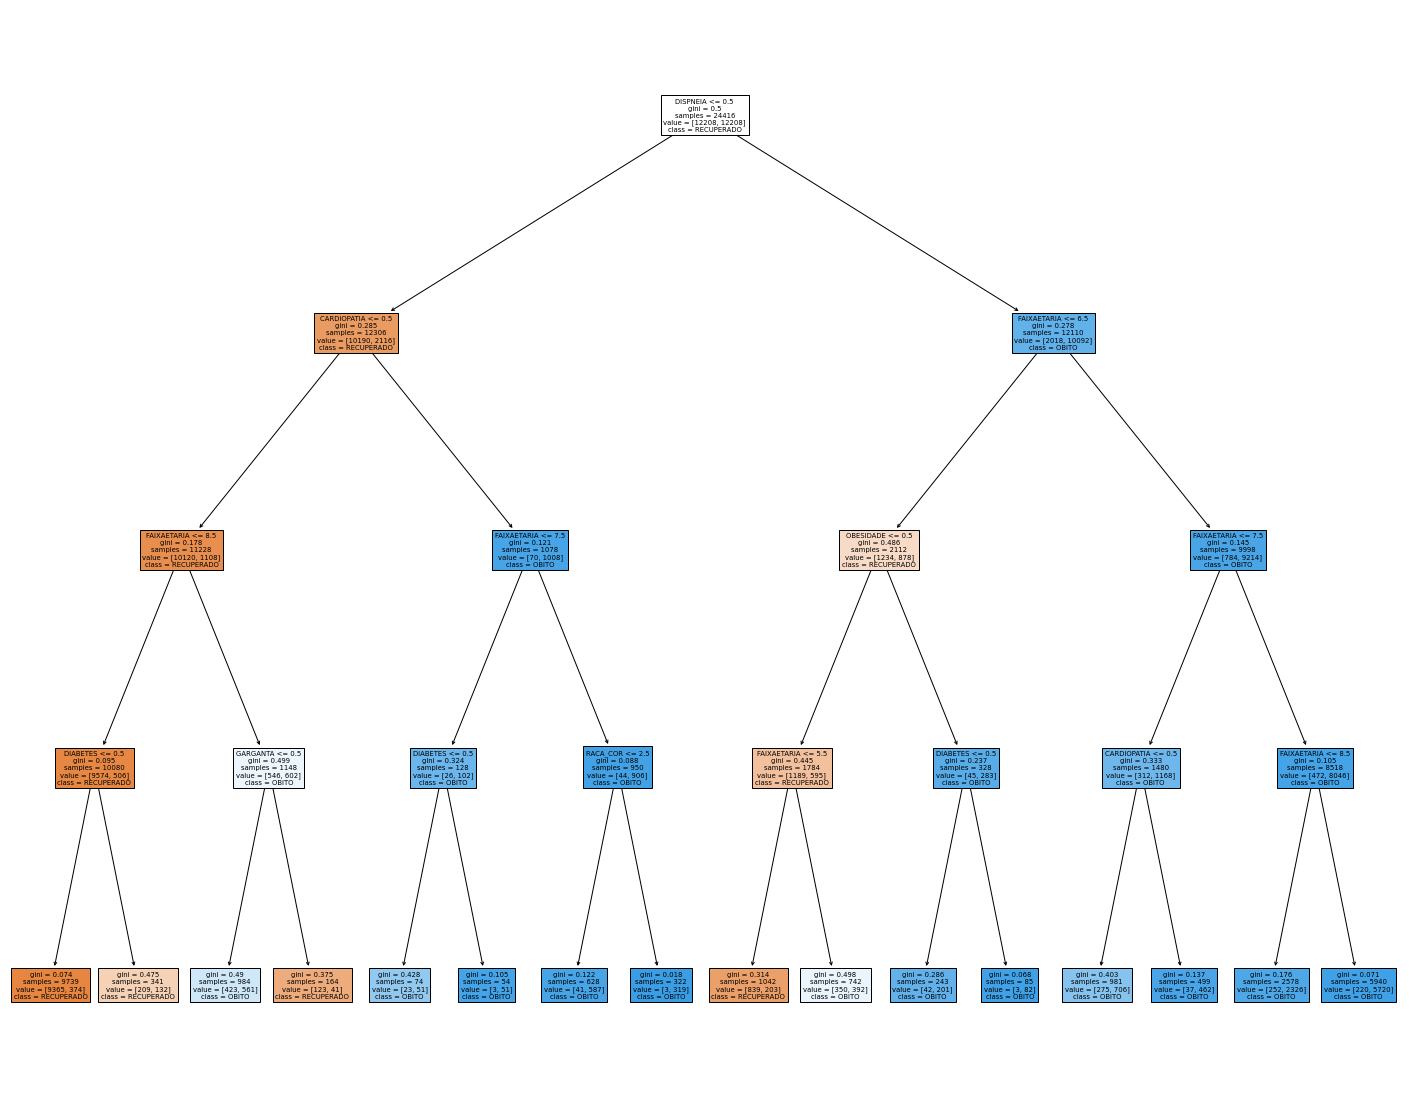

In [31]:
from sklearn import tree
clf.fit(X_rus, y_rus)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names=['RECUPERADO', 'OBITO'],
                   filled=True)
fig.savefig("tree.png", dpi=150)

In [32]:
print("accuracy: %.2f" % (results['test_accuracy'].mean() * 100))
print("precision: %.2f" % (results['test_precision'].mean() * 100))
print("recall: %.2f" % (results['test_recall'].mean() * 100))
print("f1_score: %.2f" % (results['test_f1_score'].mean() * 100))

accuracy: 89.88
precision: 87.82
recall: 92.67
f1_score: 90.15
